In [65]:
from brainiak.isc import isc,bootstrap_isc,compute_summary_statistic,isfc,squareform_isfc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from isc_tools import *

In [66]:
froot = '/data00/layerfMRI/'
datafld = froot + 'Github_repo/layerfMRI/analyses/dual_ISC/TC_4_lorenzo/'

In [67]:
summary_log = import_summary_log(froot)
movie_length = extract_movie_length(summary_log)

In [128]:
## Parameters corresponding to data to be analyzed
nbins = 7
thr = 100
method = 'M_OR_S'

input_file = datafld + f'{method}_JU_time_courses_thr{thr}_bin{nbins}.csv'

In [129]:
df = import_timecourse_dataframe(
    input_file,
    check_movie_length = True, movie_length = movie_length
)

cdf  =concatenate_movies(df,average_same_movie=False)
# cdf1 =concatenate_movies(df,average_same_movie=True)

In [130]:
## Exclude subject 11
cdf = exclude_subjects(cdf,['sub_11'])

In [131]:
## Extra layer of safety
cdf = doublecheck_same_lenght(cdf)

Contrast Motion: bin 1 of JU 200 deleted
Contrast Scrambled: bin 1 of JU 200 deleted


In [132]:
cdf = compute_isc(cdf)

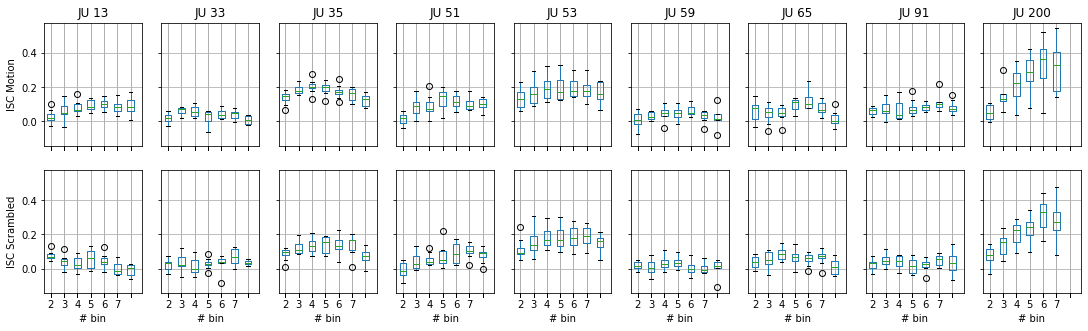

In [133]:
plot_export_isc(cdf,input_file,method)

In [138]:
isc_column = np.array([])

subJUcdf = cdf.loc[lambda d : (d['JU']==13)|(d['JU']==35)|(d['JU']==91)|(d['JU']==200)]
subJUcdf = subJUcdf.sort_values(['JU','D_bins'])
isfc_data = {}
isfc_mean_data = {}
nsub = subJUcdf['sub'].nunique()

sel_JUs = {'BA44':13, 'PFt':35, 'BA6':91, 'Vis':200}

nJU = len(sel_JUs)

for c,contrast_df in subJUcdf.groupby('contrast'):

    iscarr = np.array(list(contrast_df
     .groupby('sub')
     .apply(lambda d: np.array(list(d['tc_concatenated'])).T)
    ))

    iscarr = np.moveaxis(iscarr,0,2)
    print(iscarr.shape)

    isc_data =  isc(iscarr)
    raw_isfc = isfc(iscarr)[0]
    isfc_data[c] = np.zeros((nsub,int(nbins*nJU*(nbins*nJU-1)/2)))
    for r,sub_isfc in enumerate(raw_isfc):
        isfc_data[c][r,:] = np.arctanh(sub_isfc)    
    isfc_mean_data[c] = np.average(isfc_data[c],axis = 0)
    
    
    isc_column = np.append(isc_column,isc_data.ravel())

subJUcdf['isc'] = np.arctanh(isc_column)


(570, 27, 8)


ValueError: could not broadcast input array from shape (351) into shape (378)

In [135]:
iscarr

array([[[-0.65334623,  0.5583489 ,  0.43491001, ..., -0.33815169,
          0.88394685,  1.38561967],
        [-0.8881709 , -0.75259195, -0.61043108, ..., -0.52141719,
          1.52057362, -0.92249829],
        [-1.18523378,  1.24090854,  0.10922314, ...,  0.58728223,
         -0.24181962, -1.49331937],
        ...,
        [-0.92342028, -1.43397346, -0.24195632, ..., -1.2942013 ,
         -1.98039982, -2.25416929],
        [-1.18492249, -1.04597724,  0.17680023, ..., -2.41910012,
         -1.79607622, -2.59025108],
        [-1.07696832, -1.34040089, -1.3027467 , ..., -2.45586583,
         -1.62283463, -2.56654822]],

       [[ 0.04818444, -0.20286415,  1.39012104, ..., -1.20380642,
          1.38623168,  1.25359867],
        [-0.27597981,  0.94950712,  0.76112391, ..., -1.77325027,
          0.42515553,  0.51442707],
        [ 0.86562309, -0.37522209,  1.15083007, ..., -0.55808377,
          1.71214298, -0.58060004],
        ...,
        [ 0.83866698, -1.28354754, -0.01996321, ...,  

In [ ]:
from scipy.spatial.distance import squareform

In [ ]:
from scipy.stats import ttest_1samp,ttest_rel
from statsmodels.stats.multitest import fdrcorrection

In [ ]:


for c in ['Motion','Scrambled']:
    M = 0.2

    fig,axarr = plt.subplots(nrows = 1, ncols=1,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                             sharex=True, sharey=True, figsize = (6,6))


    z = isfc_data[c]
    t,p = ttest_1samp(z, popmean = 0, axis=0)
    pmask, pcorr = fdrcorrection(p,alpha = 0.05, is_sorted=False)

    
    z_matrix = squareform(np.average(z,axis=0)*(pmask))
    cm = axarr.imshow(z_matrix,
                        cmap = 'seismic', vmax=M,vmin=-M)
                
    fout = datafld + 'ISFC/{}_full_thr{}_bin{}.txt'.format(c,thr,nbins)
    np.savetxt(fout,z_matrix)
    
#     plt.colorbar(cm,cax = axarr[1,3])

    
    plt.suptitle(c)


In [ ]:
sel_JUs = {'BA44':13, 'PFt':35, 'BA6':91, 'Vis':200}
list_JUs = list(sel_JUs)

nJU = len(sel_JUs)

for c in isfc_mean_data:
    M = 0.25
    
    
    z = isfc_data[c]
    t,p = ttest_1samp(z, popmean = 0, axis=0)
    pmask, pcorr = fdrcorrection(p,alpha = 0.05)

    

    fig,axarr = plt.subplots(nrows = nJU, ncols=nJU,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                             sharex=True, sharey=True, figsize = (6,6))

    for ix in range(nJU):

        # Labels JU
        axarr[ix,-1].yaxis.set_label_position("right")
        axarr[ix,-1].set_ylabel(list_JUs[ix], rotation = 270, labelpad=14)
        axarr[0,ix].xaxis.set_label_position("top")
        axarr[0,ix].set_xlabel(list_JUs[ix], labelpad=4)
        # Labels bins
        axarr[ix,0].set_yticks(np.arange(0,nbins,5))
        axarr[ix,0].set_yticklabels(np.arange(0,nbins,5)+1)
        axarr[-1,ix].set_xticks(np.arange(0,nbins,5))
        axarr[-1,ix].set_xticklabels(np.arange(0,nbins,5)+1)
        axarr[ix,0].minorticks_on()
        
        for iy in range(nJU):
            

            z_matrix = squareform(np.average(z,axis=0)*(pmask))[nbins*iy:nbins*(iy+1),nbins*ix:nbins*(ix+1)]
            cm = axarr[iy,ix].imshow(z_matrix,
                                cmap = 'seismic', vmax=M,vmin=-M)


            
            fout = datafld + 'ISFC/{}_{}-{}_thr{}_bin{}.txt'.format(c,list_JUs[iy],list_JUs[ix],thr,nbins)
            np.savetxt(fout,z_matrix)

            
#     plt.colorbar(cm,cax = axarr[1,3])
    
    axarr[1,0].set_ylabel('# bin')
    axarr[-1,1].set_xlabel('# bin')
    
    plt.suptitle(c)


In [ ]:
zm = isfc_data['Motion']
zs = isfc_data['Scrambled']

t,p = ttest_rel(zm,zs, axis=0)
pmask, pcorr = fdrcorrection(p,alpha = 0.05)


fig,axarr = plt.subplots(nrows = nJU, ncols=nJU,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                         sharex=True, sharey=True, figsize = (6,6))

for ix in range(nJU):

    # Labels JU
    axarr[ix,-1].yaxis.set_label_position("right")
    axarr[ix,-1].set_ylabel(list(sel_JUs)[ix], rotation = 270, labelpad=14)
    axarr[0,ix].xaxis.set_label_position("top")
    axarr[0,ix].set_xlabel(list(sel_JUs)[ix], labelpad=4)
    # Labels bins
    axarr[ix,0].set_yticks(np.arange(0,nbins,5))
    axarr[ix,0].set_yticklabels(np.arange(0,nbins,5)+1)
    axarr[-1,ix].set_xticks(np.arange(0,nbins,5))
    axarr[-1,ix].set_xticklabels(np.arange(0,nbins,5)+1)
    axarr[ix,0].minorticks_on()
        
    for iy in range(nJU):



        z_matrix = squareform(np.average(zm-zs,axis=0)*(pmask))[nbins*iy:nbins*(iy+1),nbins*ix:nbins*(ix+1)]
        cm = axarr[iy,ix].imshow(z_matrix,
                            cmap = 'seismic', vmax=M,vmin=-M)


        
        
        fout = datafld + 'ISFC/Motion-Scrambled_{}-{}_thr{}_bin{}.txt'.format(list_JUs[iy],list_JUs[ix],thr,nbins)
        np.savetxt(fout,z_matrix)
        
#     plt.colorbar(cm,cax = axarr[1,3])
axarr[1,0].set_ylabel('# bin')
axarr[-1,1].set_xlabel('# bin')
    

plt.suptitle('Motion - Scrambled')


In [ ]:
fig,ax = plt.subplots(figsize = (0.3,6))
plt.colorbar(cm,cax = ax,orientation = 'vertical', ticks = np.arange(-0.2,M+0.1,0.1))
ax.set_ylabel('mean Z transformed ISFC')
plt.show()

## PPI-like fc

In [ ]:
isc_column = np.array([])

subJUcdf = cdf.loc[lambda d : (d['JU']==13)|(d['JU']==35)|(d['JU']==91)]
subJUcdf = subJUcdf.sort_values(['JU','D_bins'])
isfc_data = {}
isfc_mean_data = {}
nsub = subJUcdf['sub'].nunique()

sel_JUs = {'BA44':13, 'PFt':35, 'BA6':91}

nJU = len(sel_JUs)

for c,contrast_df in subJUcdf.groupby('contrast'):

    iscarr = np.array(list(contrast_df
     .groupby('sub')
     .apply(lambda d: np.array(list(d['tc_concatenated'])).T)
    ))

    iscarr = np.moveaxis(iscarr,0,2)
    
    raw_isfc = generic_isfc(iscarr,intersubject=False)
    isfc_data[c] = np.zeros((nsub,int(nbins*nJU*(nbins*nJU-1)/2)))
    for r,sub_isfc in enumerate(raw_isfc):
        isfc_data[c][r,:] = np.arctanh(sub_isfc)    
    isfc_mean_data[c] = np.average(isfc_data[c],axis = 0)
    
    
    isc_column = np.append(isc_column,isc_data.ravel())

subJUcdf['isc'] = np.arctanh(isc_column)


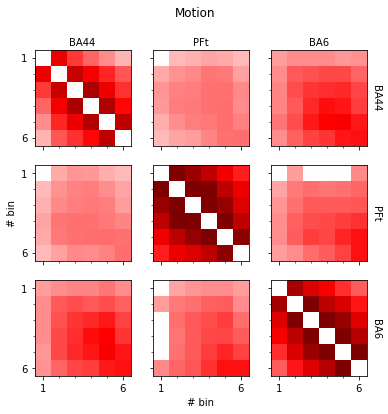

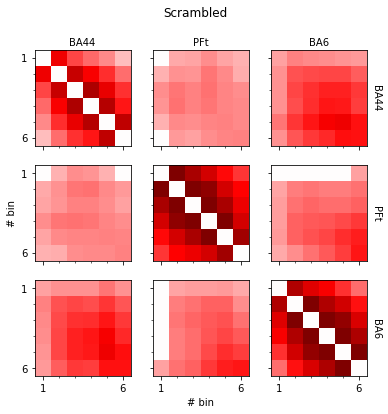

In [64]:
sel_JUs = {'BA44':13, 'PFt':35, 'BA6':91}
list_JUs = list(sel_JUs)

nJU = len(sel_JUs)

for c in isfc_mean_data:
    M = 1
    
    
    z = isfc_data[c]
    t,p = ttest_1samp(z, popmean = 0, axis=0)
    pmask, pcorr = fdrcorrection(p,alpha = 0.05)

    

    fig,axarr = plt.subplots(nrows = nJU, ncols=nJU,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                             sharex=True, sharey=True, figsize = (6,6))

    for ix in range(nJU):

        # Labels JU
        axarr[ix,-1].yaxis.set_label_position("right")
        axarr[ix,-1].set_ylabel(list_JUs[ix], rotation = 270, labelpad=14)
        axarr[0,ix].xaxis.set_label_position("top")
        axarr[0,ix].set_xlabel(list_JUs[ix], labelpad=4)
        # Labels bins
        axarr[ix,0].set_yticks(np.arange(0,nbins,5))
        axarr[ix,0].set_yticklabels(np.arange(0,nbins,5)+1)
        axarr[-1,ix].set_xticks(np.arange(0,nbins,5))
        axarr[-1,ix].set_xticklabels(np.arange(0,nbins,5)+1)
        axarr[ix,0].minorticks_on()
        
        for iy in range(nJU):
            

            z_matrix = squareform(np.average(z,axis=0)*(pmask))[nbins*iy:nbins*(iy+1),nbins*ix:nbins*(ix+1)]
            cm = axarr[iy,ix].imshow(z_matrix,
                                cmap = 'seismic', vmax=M,vmin=-M)


            
            fout = datafld + 'RESULTS/WSFC_{}_{}-{}_thr{}_bin{}.txt'.format(c,list_JUs[iy],list_JUs[ix],thr,nbins)
            np.savetxt(fout,z_matrix)

            
#     plt.colorbar(cm,cax = axarr[1,3])
    
    axarr[1,0].set_ylabel('# bin')
    axarr[-1,1].set_xlabel('# bin')
    
    plt.suptitle(c)


Text(0.5, 0.98, 'Motion - Scrambled')

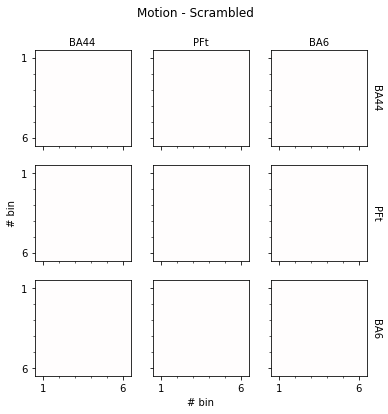

In [65]:
zm = isfc_data['Motion']
zs = isfc_data['Scrambled']

t,p = ttest_rel(zm,zs, axis=0)
pmask, pcorr = fdrcorrection(p,alpha = 0.05)


fig,axarr = plt.subplots(nrows = nJU, ncols=nJU,#+1, gridspec_kw={'width_ratios':[10]*nJU+[1]})#,
                         sharex=True, sharey=True, figsize = (6,6))

for ix in range(nJU):

    # Labels JU
    axarr[ix,-1].yaxis.set_label_position("right")
    axarr[ix,-1].set_ylabel(list(sel_JUs)[ix], rotation = 270, labelpad=14)
    axarr[0,ix].xaxis.set_label_position("top")
    axarr[0,ix].set_xlabel(list(sel_JUs)[ix], labelpad=4)
    # Labels bins
    axarr[ix,0].set_yticks(np.arange(0,nbins,5))
    axarr[ix,0].set_yticklabels(np.arange(0,nbins,5)+1)
    axarr[-1,ix].set_xticks(np.arange(0,nbins,5))
    axarr[-1,ix].set_xticklabels(np.arange(0,nbins,5)+1)
    axarr[ix,0].minorticks_on()
        
    for iy in range(nJU):



        z_matrix = squareform(np.average(zm-zs,axis=0)*(pmask))[nbins*iy:nbins*(iy+1),nbins*ix:nbins*(ix+1)]
        cm = axarr[iy,ix].imshow(z_matrix,
                            cmap = 'seismic', vmax=M,vmin=-M)


        
        
        fout = datafld + 'RESULTS/WSFC_Motion-Scrambled_{}-{}_thr{}_bin{}.txt'.format(list_JUs[iy],list_JUs[ix],thr,nbins)
        np.savetxt(fout,z_matrix)
        
#     plt.colorbar(cm,cax = axarr[1,3])
axarr[1,0].set_ylabel('# bin')
axarr[-1,1].set_xlabel('# bin')
    

plt.suptitle('Motion - Scrambled')


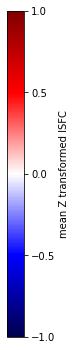

In [66]:
fig,ax = plt.subplots(figsize = (0.3,6))
plt.colorbar(cm,cax = ax,orientation = 'vertical', ticks = np.arange(-M,M+0.1,0.5))
ax.set_ylabel('mean Z transformed ISFC')
plt.show()